In [40]:
import torch
import torchvision

# Load pre-trained ResNet34 model
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model.eval()  # Set the model to evaluation mode
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet34
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [41]:
# Load pre-trained ResNet50 model
torchvision.models.resnet34(weights='IMAGENET1K_V1')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
# Load the ImageNet class labels
with open('/content/imagenet_classes.txt') as f:
    class_names = [line.strip() for line in f.readlines()]

# Create the idx2label dictionary
idx2label = {i: class_names[i] for i in range(len(class_names))}

In [43]:
# Load and preprocess the image
image_path = '/content/Donut.jpg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_tensor = preprocess(image).unsqueeze(0)

In [44]:
# Define target class
target_class = 859  # Toaster

In [45]:
def create_sticker_pattern(size):
    sticker = np.zeros((size, size, 3))
    center = size // 2
    radius = size // 2 - 2

    # Create circular sticker shape
    y, x = np.ogrid[-center:size-center, -center:size-center]
    mask = x*x + y*y <= radius*radius
    sticker[mask] = [0.8, 0.2, 0.2]  # Red color for the sticker

    # Add a simple smiley face
    cv2.circle(sticker, (center-15, center-15), 10, (1, 1, 1), -1)  # Left eye
    cv2.circle(sticker, (center+15, center-15), 10, (1, 1, 1), -1)  # Right eye
    cv2.ellipse(sticker, (center, center+10), (30, 20), 0, 0, 180, (1, 1, 1), 3)  # Smile

    return torch.from_numpy(sticker.transpose(2, 0, 1)).float().unsqueeze(0)

In [46]:
import cv2

In [47]:
# Create adversarial patch
patch_size = (100, 100)  # Increased patch size
sticker_pattern = create_sticker_pattern(patch_size[0])
patch = sticker_pattern.clone().requires_grad_(True)

#patch = torch.rand((1, 3, *patch_size), requires_grad=True)

In [48]:
# Optimizer
optimizer = optim.Adam([patch], lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)


In [49]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Function to apply patch
def apply_patch(image, patch, position, alpha=0.7):
    patched_image = image.clone()
    h, w = position
    blended_patch = alpha * patch + (1 - alpha) * sticker_pattern
    patched_image[:, :, h:h+patch_size[0], w:w+patch_size[1]] = blended_patch
    return patched_image

Iteration 0: Loss = 49.77479553222656


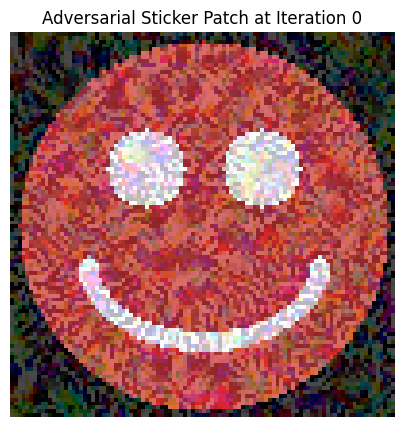

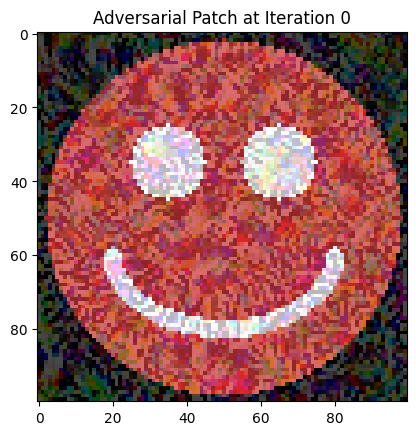

Iteration 0: Predicted Class with Patch: 931 - bagel
Iteration 100: Loss = 0.0020933272317051888


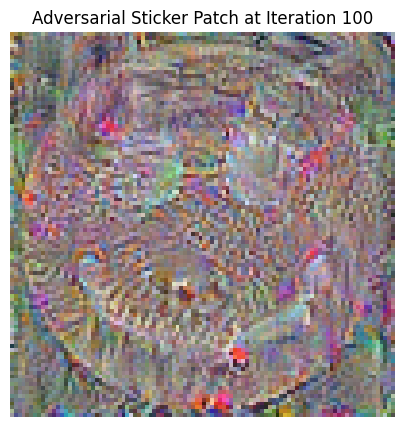

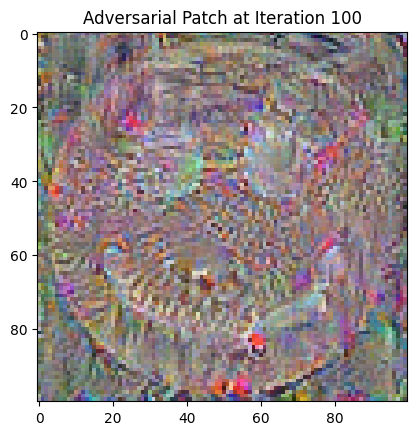

Iteration 100: Predicted Class with Patch: 859 - toaster
Success! Image classified as target class at iteration 100


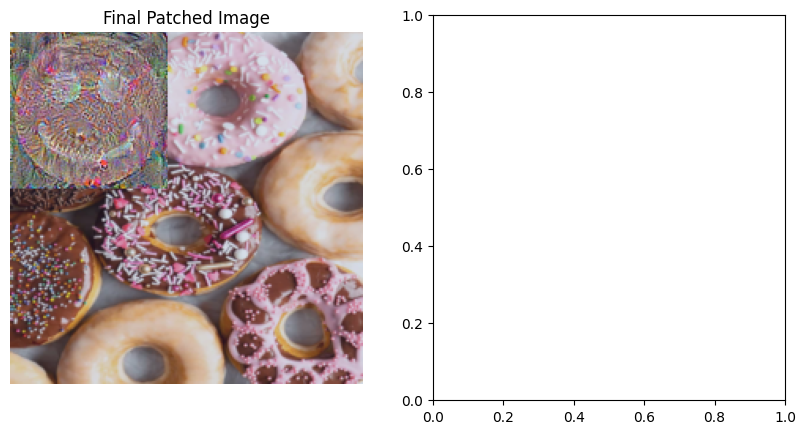

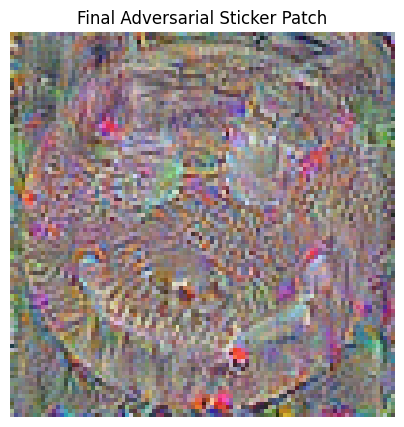

In [52]:
# Training loop
num_iterations = 3000
for i in range(num_iterations):
    # Try different positions
    positions = [(0, 0), (0, 124), (124, 0), (124, 124)]
    total_loss = 0

    for pos in positions:
        patched_img = apply_patch(img_tensor, patch, pos, alpha=0.7)
        output = model(patched_img)
        loss = criterion(output, torch.tensor([target_class]))
        total_loss += loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    scheduler.step()


    def visualize_patch(patch, title):
      patch_np = patch.detach().squeeze().permute(1, 2, 0).cpu().numpy()
      patch_np = (patch_np - patch_np.min()) / (patch_np.max() - patch_np.min())
      plt.figure(figsize=(5, 5))
      plt.imshow(patch_np)
      plt.title(title)
      plt.axis('off')
      plt.show()

    if i % 100 == 0:
        print(f"Iteration {i}: Loss = {total_loss.item()}")
        visualize_patch(patch, f"Adversarial Sticker Patch at Iteration {i}")

        # Visualize the patch
        patch_np = patch.detach().squeeze().permute(1, 2, 0).cpu().numpy()
        patch_np = (patch_np - patch_np.min()) / (patch_np.max() - patch_np.min())
        plt.imshow(patch_np)
        plt.title(f"Adversarial Patch at Iteration {i}")
        plt.show()

        # Check if the attack is successful
        with torch.no_grad():
          patched_img = apply_patch(img_tensor, patch, (0, 0))
          output = model(patched_img)
          _, predicted = torch.max(output, 1)
          predicted_class = predicted.item()
          predicted_class_name = idx2label[predicted_class]
          print(f"Iteration {i}: Predicted Class with Patch: {predicted_class} - {predicted_class_name}")
          if predicted_class == target_class:
            print(f"Success! Image classified as target class at iteration {i}")
            break

# Visualize final patched image
final_img = apply_patch(img_tensor, patch, (0, 0), alpha=0.7)
final_img_np = final_img.detach().squeeze().permute(1, 2, 0).cpu().numpy()
final_img_np = (final_img_np - final_img_np.min()) / (final_img_np.max() - final_img_np.min())
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(final_img_np)
plt.title("Final Patched Image")
plt.axis('off')
plt.subplot(1, 2, 2)
visualize_patch(patch, "Final Adversarial Sticker Patch")
plt.show()
